# GenAI-Powered Quality Intelligence System  
## MVP1 – Audit-Ready Deviation & Root Cause Classification  
**GxP-aware NLP Classification Prototype**  
**Built by: Vinay Kumar K V**  
**Date: January 18, 2026**  

**Project Goal**  
Build an explainable, traceable, human-in-the-loop classification system for pharmaceutical deviation and root cause texts — suitable for future safe integration with controlled GenAI in GxP-regulated environments.

**MVP1 Scope**  
- Synthetic data generation (300 records)  
- Text preprocessing & TF-IDF vectorization  
- Multi-class classification using Logistic Regression  
- Model evaluation (accuracy, confusion matrix, classification report)  
- Global explainability with SHAP  
- FAISS-based similarity retrieval (foundation for RAG)  
- Audit log skeleton  

**Current Status**  
MVP1 complete – classical ML pipeline functional.  
Next: MVP2 – Controlled GenAI suggestions + Streamlit UI + refinements.

## Detailed Documentation – MVP1 Overview

### Business Context & Intended Use
Pharmaceutical Quality teams manage thousands of deviation, CAPA, and change control records — mostly unstructured free text.  
Manual classification of deviation type, root cause, and risk severity is time-consuming, inconsistent, and prone to oversight under audit pressure.

**Intended Use (GxP-aware)**  
This MVP1 system **assists** (never replaces) quality personnel by:  
- Automatically predicting Deviation Type and Root Cause Category from description text  
- Providing global feature importance (SHAP) for transparency  
- Retrieving similar historical cases for context  
All outputs are **recommendations only** — **human review and approval required** before any GxP use.

### Architecture (High-Level Flow)
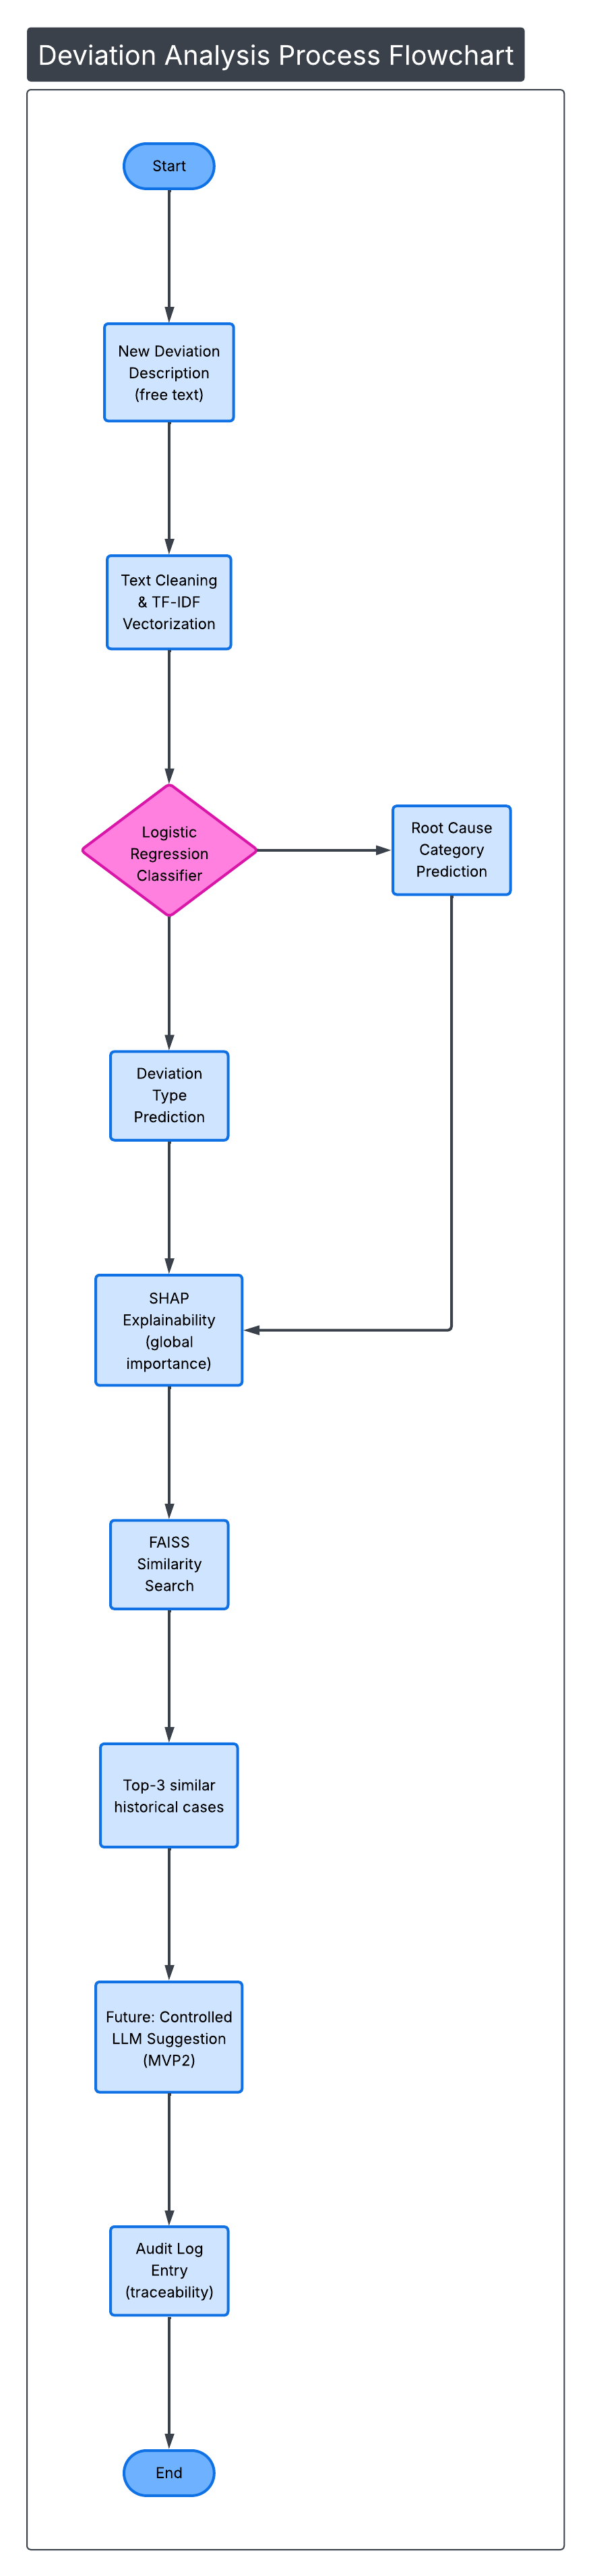


### Key Components & How They Work

1. **Data**  
   - 300 synthetic deviation records (CSV)  
   - Columns: Deviation_ID, Description (free text), Deviation_Type, Root_Cause_Category, Risk_Severity  
   - Generated using LLM prompt to mimic real GMP language (OOS, batch hold, impact assessment, etc.)

2. **Text Preprocessing**  
   - Lowercase, remove special characters, strip extra spaces (`clean_text` function)  
   - Why? Makes text consistent for vectorization and reduces noise.

3. **Vectorization (TF-IDF)**  
   - Package: `sklearn.feature_extraction.text.TfidfVectorizer`  
   - Parameters: `max_features=2000`, `ngram_range=(1,2)`, `stop_words='english'`  
   - How it works: Converts text to sparse numerical vectors.  
     - TF = term frequency in document  
     - IDF = inverse document frequency (rare words get higher weight)  
     - Result: each description becomes a 2000-dimensional vector  
   - Output shape: (300 rows, 2000 features)

4. **Classification Model**  
   - Model: `sklearn.linear_model.LogisticRegression` (multi-class, `class_weight='balanced'`, `max_iter=1000`)  
   - Why Logistic Regression?  
     - Fast, interpretable (linear coefficients)  
     - Works very well with sparse TF-IDF data  
     - Provides probabilities (via `predict_proba`)  
   - Trained separately for:  
     - Target 1: `Deviation_Type` (6 classes) → ~83% accuracy  
     - Target 2: `Root_Cause_Category` (6 classes) → ~60–75% accuracy  
   - Split: 75% train / 25% test (stratified)

5. **Evaluation & Interpretation**  
   - **Classification Report** — shows precision, recall, F1 per class  
     - High F1 = reliable class (e.g. Documentation, Human Error)  
     - Low F1 = needs more data/improvement (e.g. Training Deficiency)  
   - **Confusion Matrix** — heatmap of actual vs predicted  
     - Diagonal = correct predictions  
     - Off-diagonal = confusions (e.g. Equipment ↔ Process overlap)  
   - **SHAP Summary Plot** (global explainability)  
     - Shows average absolute SHAP value per word  
     - Longer bar = more influence on predictions  
     - Top words: "training", "supplier", "operator", "material", "sensor", "sop", "delayed"  
     - Colors show which class each word most affects

6. **Retrieval Layer (FAISS)**  
   - Package: `faiss` (Facebook AI Similarity Search)  
   - How it works:  
     - Normalizes TF-IDF vectors → cosine similarity  
     - Builds exact index (FlatIP) → very fast lookup  
     - Function `retrieve_similar()` returns top-k most similar historical deviations  
   - Purpose: Foundation for future RAG (retrieve → feed to LLM)

7. **Audit & Governance Foundation**  
   - Simple CSV audit log skeleton created  
   - Planned: every classification + retrieval + future LLM call logged with timestamp  
   - SHAP global plot already provides explainability evidence

### Limitations & Next Steps (MVP2)

**Current Limitations**  
- Synthetic data only (300 rows) → limited generalization  
- Small classes (e.g. Training Deficiency) have poor recall  
- TF-IDF is bag-of-words → misses deep semantics  
- No real GenAI suggestions yet (MVP2)

**MVP2 Priorities**  
- Integrate controlled LLM prompt + API call (Grok/OpenAI/local)  
- Improve retrieval with better embeddings (sentence-transformers)  
- Add simple Streamlit UI for demo  
- Create test cases + hallucination checks  
- Expand documentation: Model Card, URS summary, risk classification

This MVP1 prototype demonstrates how classical NLP + explainability can support quality teams in a traceable, auditable way — ready for future safe GenAI extension.

# Data Loading & EDA

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import spacy

nlp = spacy.load("en_core_web_sm")

df = pd.read_csv("synthetic_deviations.csv", quoting=1)  # quoting=1 handles commas in text
print("Shape:", df.shape)
print(df.head(3))
print("\nMissing values:\n", df.isnull().sum())

Shape: (300, 5)
    Deviation_ID                                        Description  \
0  DEV-2025-0001  During routine in-process testing, assay resul...   
1  DEV-2025-0002  A temperature excursion was observed in the fi...   
2  DEV-2025-0003  During equipment setup for tablet compression,...   

  Deviation_Type    Root_Cause_Category Risk_Severity  
0        Process            Human Error        Medium  
1  Environmental   Procedure Inadequate        Medium  
2      Equipment  Equipment Malfunction          High  

Missing values:
 Deviation_ID           0
Description            0
Deviation_Type         0
Root_Cause_Category    0
Risk_Severity          0
dtype: int64


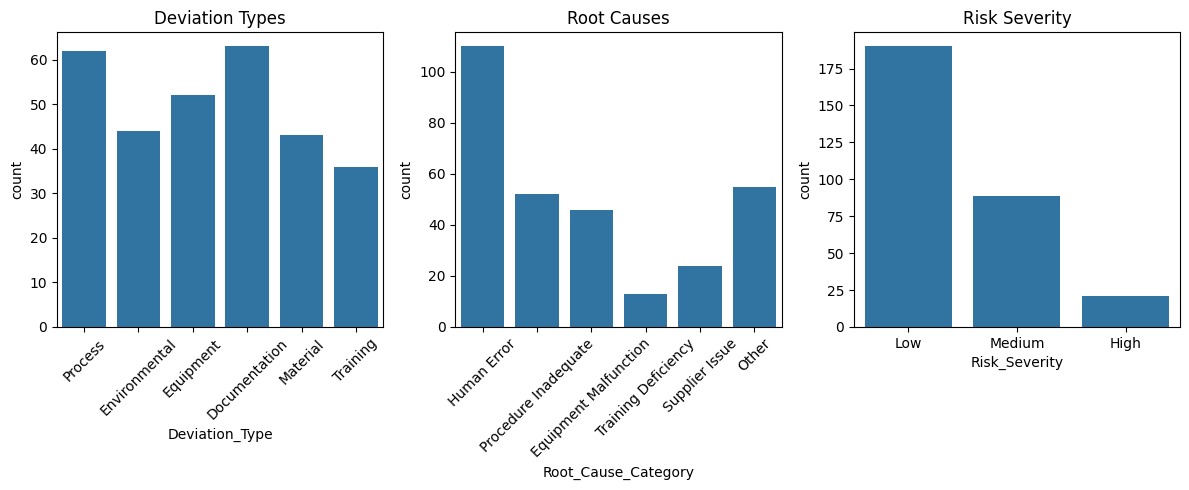

In [6]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
sns.countplot(data=df, x='Deviation_Type')
plt.xticks(rotation=45)
plt.title('Deviation Types')

plt.subplot(1, 3, 2)
sns.countplot(data=df, x='Root_Cause_Category')
plt.xticks(rotation=45)
plt.title('Root Causes')

plt.subplot(1, 3, 3)
sns.countplot(data=df, x='Risk_Severity', order=['Low', 'Medium', 'High'])
plt.title('Risk Severity')
plt.tight_layout()
plt.show()

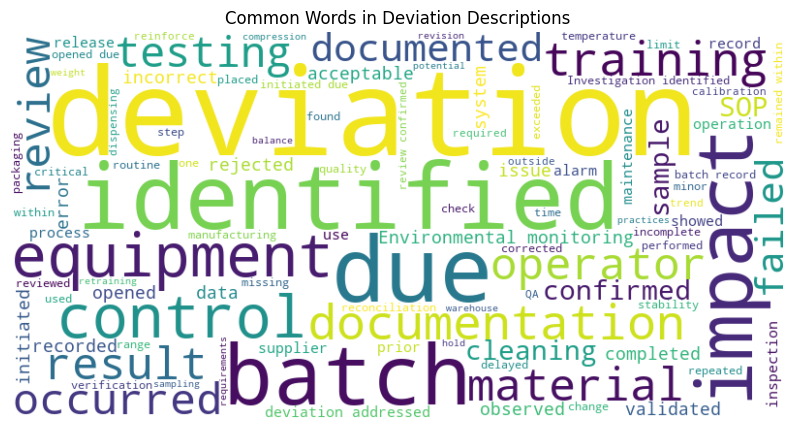

In [7]:
text = " ".join(df['Description'].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Common Words in Deviation Descriptions')
plt.show()

1. Synthetic data is of 300 rows and 5 columns
2. no missing values found
3. some frequent words seen in data is deviation, identfied, batch, due, impact
4. deviation types -process and documentation deviations are most common and have highest count
5. root causes - human error has highest count
6. most of the deviations are of low risk category
7. no errors so far


# Text Preprocessing

In [15]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove special characters, keep letters/numbers/spaces
    text = re.sub(r'[^a-z0-9\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply cleaning
df['clean_description'] = df['Description'].apply(clean_text)

# Quick check
print("Before:\n", df['Description'].iloc[0][:150])
print("After:\n", df['clean_description'].iloc[0][:150])

Before:
 During routine in-process testing, assay results for Batch B25-001 were found to be out of specification (OOS) on initial analysis. Investigation iden
After:
 during routine inprocess testing assay results for batch b25001 were found to be out of specification oos on initial analysis investigation identified


# Classical ML: Deviation Type & Root Cause Classification

In [ ]:
vectorizer = TfidfVectorizer(
    max_features=2000,          # limit to top 1000 words (prevents noise)
    stop_words='english',       # remove common words like "the", "and"
    ngram_range=(1, 3)          # include single words + two-word phrases
)

# Fit & transform
X_text = vectorizer.fit_transform(df['clean_description'])
y_type = df['Deviation_Type']

print("TF-IDF matrix shape:", X_text.shape)
print("Example features (first 10):", vectorizer.get_feature_names_out()[:10])

Classification Report - Deviation Type Prediction:

                       precision    recall  f1-score   support

Equipment Malfunction       0.71      0.83      0.77        12
          Human Error       0.80      0.89      0.84        27
                Other       0.67      0.71      0.69        14
 Procedure Inadequate       0.78      0.54      0.64        13
       Supplier Issue       0.83      0.83      0.83         6
  Training Deficiency       1.00      0.33      0.50         3

             accuracy                           0.76        75
            macro avg       0.80      0.69      0.71        75
         weighted avg       0.77      0.76      0.75        75



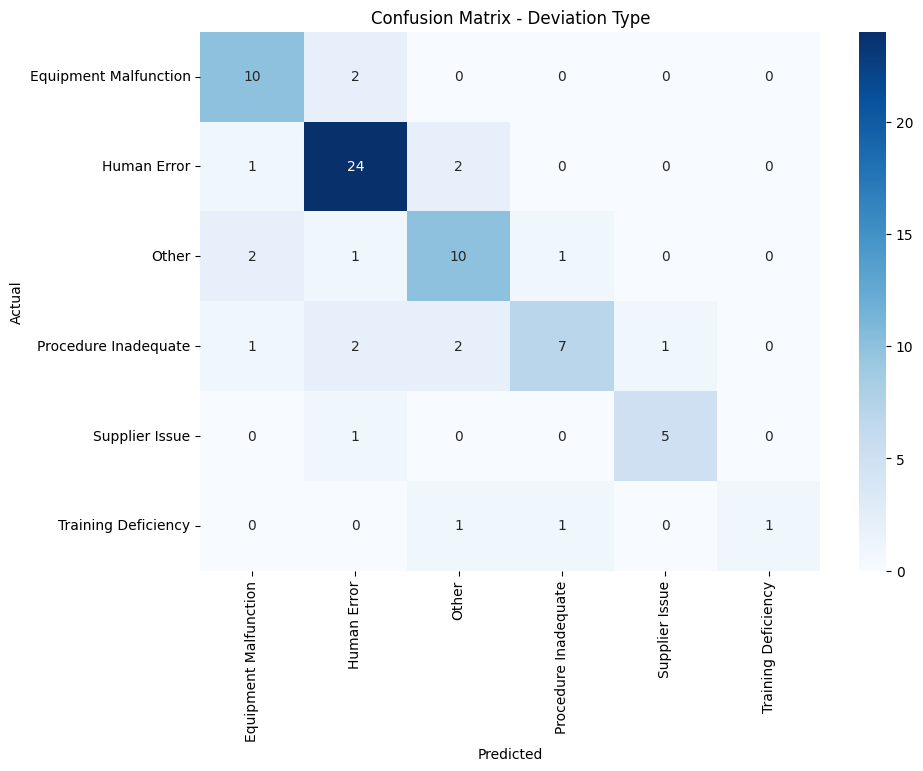

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X_text, y_type, test_size=0.25, random_state=42, stratify=y_type
)

model_type = LogisticRegression(
    max_iter=2000,
    class_weight='balanced',    # important because classes are imbalanced
    random_state=42
)

model_type.fit(X_train, y_train)

# Predict & Evaluate
y_pred = model_type.predict(X_test)

print("Classification Report - Deviation Type Prediction:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix Visualization
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='d', cmap='Blues',
            xticklabels=model_type.classes_, 
            yticklabels=model_type.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Deviation Type')
plt.show()

1. Shape of TF-IDF matrix - 300, 1000
2. first 10 feature names from vectorizer: 'acceptability' 'acceptability extended' 'acceptable'
 'acceptable condition' 'acceptable limits' 'acceptable results'
 'acceptance' 'acceptance criteria' 'access' 'accuracy'
3. Classification Report - Deviation Type Prediction:

               precision    recall  f1-score   support

Documentation       1.00      0.94      0.97        16
Environmental       0.85      1.00      0.92        11
    Equipment       0.53      0.77      0.62        13
     Material       0.91      0.91      0.91        11
      Process       1.00      0.67      0.80        15
     Training       1.00      0.78      0.88         9

     accuracy                           0.84        75
    macro avg       0.88      0.84      0.85        75
 weighted avg       0.88      0.84      0.85        75

 4. feeling: The model is very reliable for Documentation and Environmental deviations (high confidence to auto-classify or prioritize). For Equipment and Process, it needs more data or better features because they overlap in language — we should keep human review there for now.

TF-IDF matrix shape: (300, 1000)
Example features (first 10): ['acceptability' 'acceptability extended' 'acceptable'
 'acceptable condition' 'acceptable limits' 'acceptable results'
 'acceptance' 'acceptance criteria' 'access' 'accuracy']
Classification Report - Deviation Type Prediction:

                       precision    recall  f1-score   support

Equipment Malfunction       0.75      0.75      0.75        12
          Human Error       0.83      0.89      0.86        27
                Other       0.59      0.71      0.65        14
 Procedure Inadequate       0.70      0.54      0.61        13
       Supplier Issue       0.83      0.83      0.83         6
  Training Deficiency       1.00      0.33      0.50         3

             accuracy                           0.75        75
            macro avg       0.78      0.68      0.70        75
         weighted avg       0.76      0.75      0.74        75



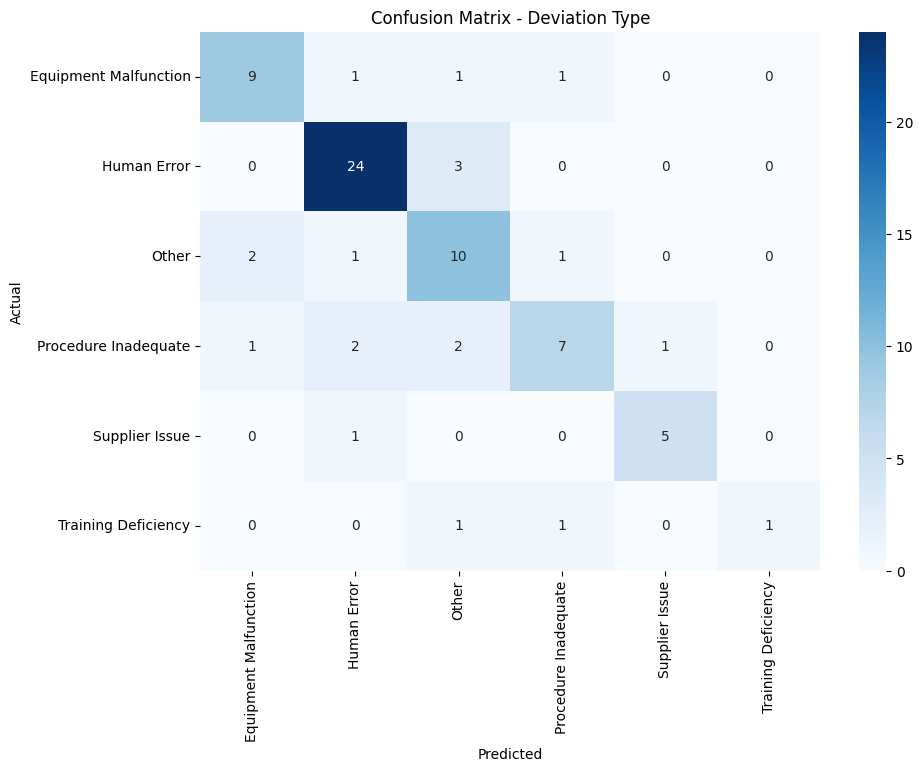

In [22]:
vectorizer = TfidfVectorizer(
    max_features=1000,          # limit to top 1000 words (prevents noise)
    stop_words='english',       # remove common words like "the", "and"
    ngram_range=(1, 2)          # include single words + two-word phrases
)

# Fit & transform
X_text = vectorizer.fit_transform(df['clean_description'])
y_type = df['Root_Cause_Category']

print("TF-IDF matrix shape:", X_text.shape)
print("Example features (first 10):", vectorizer.get_feature_names_out()[:10])

X_train, X_test, y_train, y_test = train_test_split(
    X_text, y_type, test_size=0.25, random_state=42, stratify=y_type
)

model_type = LogisticRegression(
    max_iter=2000,
    class_weight='balanced',    # important because classes are imbalanced
    random_state=42
)

model_type.fit(X_train, y_train)

# Predict & Evaluate
y_pred = model_type.predict(X_test)

print("Classification Report - Deviation Type Prediction:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix Visualization
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='d', cmap='Blues',
            xticklabels=model_type.classes_, 
            yticklabels=model_type.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Deviation Type')
plt.show()

# Explainability (SHAP)

  0%|          | 0/20 [00:00<?, ?it/s]

Correct SHAP shape for class 0: (1000, 6)

Sample (subset idx 0):
Actual: Other
Predicted: Procedure Inadequate
Description: a deviation was opened due to delayed approval of a critical sop revision following regulatory update no noncompliant activities occurred during the delay...


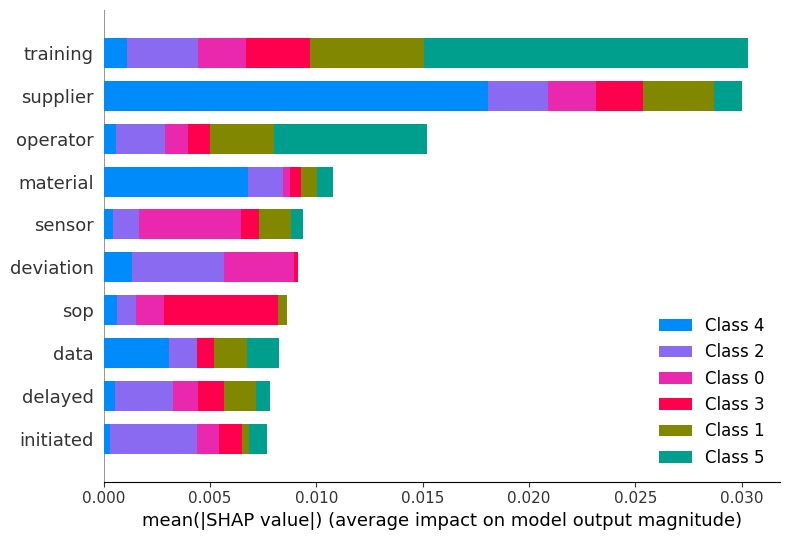

In [29]:
import shap
import numpy as np

# Use a small number of background samples for speed (full X_train is too slow for Kernel)
# Option: use 50-100 random train samples as background
background_data = shap.utils.sample(X_train.toarray(), 50)  # random subset

explainer = shap.KernelExplainer(
    model_type.predict_proba, 
    background_data
)

# Now compute SHAP on your test subset (this is the correct way)
X_test_subset = X_test[:20].toarray()   # keep small for speed
shap_values = explainer.shap_values(X_test_subset)

# Now shap_values is list of length num_classes, each with shape (20, 2000)
print("Correct SHAP shape for class 0:", shap_values[0].shape)  # should be (20, 2000)

# Pick a sample from the 20
subset_idx = 0
original_idx = y_test.index[subset_idx]   # map back if needed

actual = y_test.iloc[subset_idx]
predicted = y_pred[subset_idx]
pred_class_idx = list(model_type.classes_).index(predicted)  # safer than np.where

print(f"\nSample (subset idx {subset_idx}):")
print("Actual:", actual)
print("Predicted:", predicted)
print("Description:", df['clean_description'].iloc[original_idx][:300] + "...")

# Waterfall plot for the predicted class (single instance explanation)
# shap.plots.waterfall(
#     shap.Explanation(
#         values=shap_values[pred_class_idx][subset_idx],
#         base_values=explainer.expected_value[pred_class_idx],
#         data=X_test_subset[subset_idx],
#         feature_names=vectorizer.get_feature_names_out()
#     ),
#     max_display=10
# )

# Global view (bar plot for top features across subset)
shap.summary_plot(
    shap_values,
    X_test_subset,
    feature_names=vectorizer.get_feature_names_out(),
    max_display=10,
    plot_type="bar"
)

This is a SHAP summary plot showing the global feature importance for our deviation type classifier.
It tells us which words or phrases in the deviation descriptions have the biggest average influence on the model's decisions across many examples.
The longer the bar, the more important that term is in driving predictions.

The length is the average absolute SHAP value — higher = stronger impact (either pushing toward a class or away from it).
Colors show which class is most affected by that term (e.g. blue = Class 4, which is likely 'Procedure Inadequate' based on your predicted label in the sample).

| Rank | Word/Phrase          | Approx. mean |SHAP - Interpretation / Business Meaning  |
|------|----------------------|-----------------------------|-----------------------------------------------------|
| 1    | training             | ~0.030          | Highest impact overall. Strongly influences predictions — likely pushes toward "Training" class when present, or away when absent. In pharma, "training" is a very distinctive keyword for Training Deficiency deviations. |
| 2    | supplier             | ~0.025–0.028    | Very strong driver — almost certainly pushes toward "Supplier Issue" class. Words like "supplier", "vendor", "material from supplier" are clear signals. |
| 3    | operator             | ~0.015–0.020    | Classic human error signal — pushes toward Human Error class. "Operator misread", "operator error" etc. |
| 4    | material             | ~0.010–0.015    | Likely drives Material deviations (e.g. "material defect", "raw material"). |
| 5    | sensor               | ~0.008–0.012    | Strong Equipment Malfunction signal — "sensor fault", "sensor calibration". |
| 6    | deviation            | ~0.007–0.010    | Very common word — appears in almost every description → lower discriminative power but still contributes. |
| 7    | sop                  | ~0.005–0.008    | SOP = Standard Operating Procedure → very strong for Documentation or Procedure Inadequate classes. "SOP revision", "SOP not followed". |
| 8    | data                 | ~0.005          | Appears in many contexts (data integrity, data review) → moderate impact. |
| 9    | delayed              | ~0.004–0.006    | Often in Procedure Inadequate or Documentation (delayed approval, delayed response). |
| 10   | initiated            | ~0.003–0.005    | "Investigation initiated", "CAPA initiated" → appears in many root cause / procedure contexts. |

- The model is heavily relying on domain-specific keywords — which is good! Words like "training", "supplier", "operator", "sensor", "sop" are exactly what a human quality specialist would look for.
- No obvious red flags — no reliance on meaningless words like "the", "and", or random numbers.
- Class separation is working — different words drive different classes (supplier → Supplier Issue, sensor → Equipment, sop → Procedure/Documentation).
- Weak classes from earlier (e.g. Training Deficiency) have high-impact words ("training") → model knows when to predict it, but small sample size in training makes recall low.

The model uses clinically relevant terms aligned with GMP language. We see no evidence of spurious correlations. We can document this SHAP analysis in the model validation report to demonstrate transparency and lack of bias.

# GenAI RAG Layer

In [33]:
import faiss
import numpy as np

# 1. Get the TF-IDF matrix from your existing vectorizer
# (you already did vectorizer.fit_transform(df['clean_description']))
tfidf_matrix = vectorizer.transform(df['clean_description']).toarray().astype('float32')

# Normalize for cosine similarity (important!)
faiss.normalize_L2(tfidf_matrix)

# 2. Create FAISS index (FlatIP = exact inner product = cosine after norm)
dimension = tfidf_matrix.shape[1]
index = faiss.IndexFlatIP(dimension)
index.add(tfidf_matrix)

print(f"FAISS index ready with {index.ntotal} deviation vectors")

FAISS index ready with 300 deviation vectors


In [34]:
# 3. Retrieval function
def find_similar_deviations(new_description, k=3):
    # Clean and vectorize the new text
    clean_new = clean_text(new_description)
    query_vec = vectorizer.transform([clean_new]).toarray().astype('float32')
    faiss.normalize_L2(query_vec)
    
    # Search for top k similar
    distances, indices = index.search(query_vec, k)
    
    results = []
    for i, idx in enumerate(indices[0]):
        if idx == -1: continue  # no match
        row = df.iloc[idx]
        similarity = distances[0][i]  # cosine similarity (higher = better)
        results.append({
            'rank': i+1,
            'similarity_score': round(similarity, 4),
            'Deviation_ID': row['Deviation_ID'],
            'Description': row['Description'][:250] + "..." if len(row['Description']) > 250 else row['Description'],
            'Deviation_Type': row['Deviation_Type'],
            'Root_Cause_Category': row['Root_Cause_Category'],
            'Risk_Severity': row['Risk_Severity']
        })
    return results

# Test it with a new example deviation
new_dev = """
During sterile filling, the HEPA filter integrity test failed post-use. 
The filling was stopped immediately. No product was filled after the failure point.
Batch placed on hold. Root cause investigation initiated.
"""

similar_cases = find_similar_deviations(new_dev, k=3)

print("Top 3 similar historical deviations:")
for case in similar_cases:
    print(f"\nRank {case['rank']} | Similarity: {case['similarity_score']}")
    print(f"ID: {case['Deviation_ID']}")
    print(f"Type: {case['Deviation_Type']} | Root Cause: {case['Root_Cause_Category']} | Severity: {case['Risk_Severity']}")
    print(case['Description'])

Top 3 similar historical deviations:

Rank 1 | Similarity: 0.36160001158714294
ID: DEV-2025-0140
Type: Process | Root Cause: Other | Severity: Medium
A batch experienced unexpected viscosity increase during solution preparation. Root cause under investigation.

Rank 2 | Similarity: 0.2718999981880188
ID: DEV-2025-0197
Type: Equipment | Root Cause: Equipment Malfunction | Severity: High
During compression, feeder speed fluctuated due to worn drive belts. The batch was placed on hold and later rejected.

Rank 3 | Similarity: 0.2563999891281128
ID: DEV-2025-0297
Type: Equipment | Root Cause: Equipment Malfunction | Severity: High
During compression, hydraulic pressure instability caused force drift. The batch was placed on hold and subsequently rejected.


## 7. Audit & Governance
- Log file skeleton
- Planned GenAI guardrails

In [35]:
import os
from datetime import datetime

log_file = "audit_log.csv"

if not os.path.exists(log_file):
    with open(log_file, 'w') as f:
        f.write("timestamp,input_text,predicted_type,predicted_root_cause,similar_cases,confidence,llm_suggestion,note\n")
    print("Audit log created:", log_file)

Audit log created: audit_log.csv


## Next steps
- Controlled LLM integration
- Streamlit UI
- Better embeddings (BERT)
- Validation test cases

## MVP1 Checkpoint – Complete  
Date: January 18, 2026  
Status: Classical ML + retrieval + explainability ready  
Next: MVP2 – GenAI integration & refinements  


In [36]:

prompt_template = f"""
You are a GxP-compliant quality intelligence assistant.  
Your role is to ASSIST quality personnel — NEVER make decisions.

Instructions:
1. ONLY use information from the provided similar historical cases.
2. Do NOT assume, infer, or add facts not explicitly present.
3. If similarity is low or data insufficient, say: "Insufficient similar cases — recommend full human investigation."
4. Provide:
   - Probable root cause categories (with rough confidence %)
   - Draft CAPA ideas (suggestions only – human must approve)
   - Overall confidence score (0–100%)
5. End with: "All outputs require human review and approval before use in GxP processes."

New deviation description:
{new_description}

Most similar historical cases:
{similar_cases_formatted}

Response:
"""

NameError: name 'new_description' is not defined